# ACE estimations from real observational data
*This notebook examines the use of the `CausalEffectEstimation` module for estimating Average Causal Effects (ACE) in Observational Studies within the Neyman-Rubin potential outcome framework from real data:* 

In [4]:
import pyAgrum as gum
import pyAgrum.skbn.discretizer as disc
import pyAgrum.lib.explain as gexpl
import pyAgrum.lib.notebook as gnb

import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

import numpy as np
import pandas as pd

from scipy.stats import gaussian_kde

pd.set_option('future.no_silent_downcasting', True)

### Dataset
The dataset under consideration is the Census Adult Income dataset.
The objective of this analysis is to determine whether possessing a graduate degree increases the likelihood of earning an income exceeding $50,000 per year.

In [5]:
df = pd.read_pickle("../data/df_causal_discovery.p")
df.head()

,age,hours-per-week,hasGraduateDegree,inRelationship,isWhite,isFemale,greaterThan50k
0,39,40,0,0,1,0,0
1,50,13,0,1,1,0,0
2,38,40,0,0,1,0,0
3,53,40,0,1,0,0,0
5,37,40,1,0,1,1,0


In [6]:
df.describe()

,age,hours-per-week,hasGraduateDegree,inRelationship,isWhite,isFemale,greaterThan50k
count,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000
mean,38.655674,40.447755,0.052348,0.406616,0.878334,0.331916,0.245835
std,13.722408,12.417203,0.222732,0.491211,0.326905,0.470909,0.430588
min,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,40.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,37.000000,40.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,48.000000,45.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,90.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Preparation and Setup
We begin by focusing exclusively on the age covariate to inform our estimations. We hypothesize that age is a causal factor influencing both the hasGraduateDegree variable and the greaterThan50k outcome.

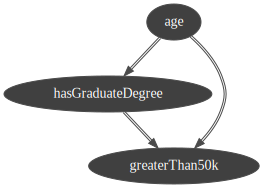

In [7]:
discretizer = disc.Discretizer(defaultDiscretizationMethod="NoDiscretization", defaultNumberOfBins=None)
template = discretizer.discretizedTemplate(df[["age", "hasGraduateDegree", "greaterThan50k"]])
template.addArcs([("age","hasGraduateDegree"), ("age", "greaterThan50k"), ("hasGraduateDegree", "greaterThan50k")])

causal_model = csl.CausalModel(template)

cslnb.showCausalModel(causal_model, size="50")

In [8]:
T = "hasGraduateDegree"
Y = "greaterThan50k"
X = "age"

In [9]:
cee = csl.CausalEffectEstimation(df, causal_model)

In [10]:
cee.identifyAdjustmentSet(intervention=T, outcome=Y)

okokokok
okokokok
Backdoor adjustment found. 

Supported estimators include:
- CausalModelEstimator
- SLearner
- TLearner
- XLearner
- PStratification
- IPW


'Backdoor'

In [11]:
cee.fitCausalBNEstimator()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 0.2332334047559898


In [12]:
cee.fitSLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 0.2976051357033038


In [13]:
cee.fitIPW()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 0.2903849161738249


Let's examine whether incorporating all available covariates influences the estimation of the ACE. We will employ structure learning techniques to determine the DAG that the algorithm identifies from the data.

In [14]:
discretizer = disc.Discretizer(defaultNumberOfBins=5, defaultDiscretizationMethod="uniform")
template = discretizer.discretizedTemplate(df)

In [26]:
structure_learner = gum.BNLearner(df, template)
structure_learner.useNMLCorrection()
structure_learner.useSmoothingPrior(1e-6)

learned_bn = structure_learner.learnBN()

causal_model = csl.CausalModel(learned_bn)

In [27]:
gnb.sideBySide(gexpl.getInformation(learned_bn, size="50"))

In [28]:
cee = csl.CausalEffectEstimation(df, causal_model)

In [29]:
cee.identifyAdjustmentSet(intervention=T, outcome=Y)

No adjustment set found among: RCT, Backdoor, Generalized Frontdoor, or Generalized IV.

The only supported estimator without a known adjustment is the Causal Bayesian Network Estimator, which can estimate the causal effect if identifiable using do-Calculus.
Use `.fitCausalBNEstimator()` to apply this estimator.


'Unknown'

In [30]:
causal_model.backDoor(T, Y)

Here, we encounter the case where no adjustment set is avilable.
As it is not an RCT since there is a backdoor paths from `hasGraduateDegree` to `greaterThen50k` goinf through `age` and `inRelationship`. Blocking the `inRelationship` variable
in this case, we can only use the `CausalBNEstimator` to estimate the causal effect, if the causal effect of the intervention on the outcome is identifiable via do-Calulus.

Another alternative is to 

We observe a higher estimated Average Treatment Effect (ATE) when incorporating all covariates compared to the estimation that accounts only for the `age` covariate.